In [75]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
import cv2

import os
import h5py

In [37]:
DATA_PATH = '/mnt/data2/pushany_rollouts_as_hdf5'

In [38]:
#get list of all directories in 1 levels in DATA_PATH
dirs = [f.name for f in os.scandir(DATA_PATH) if f.is_dir()]
print(dirs)


['reg4', 'reg3', '8', 'reg5', 'rectangle', '4', '7', 'reg8', '2', '9', 't', 'reg6', 'reg9', '0', 'reg7', '6', '5', 'reg10', 'ellipse', '3', '1']


In [96]:
target_dir = dirs[2]
frame_dir = os.path.join(DATA_PATH, target_dir, 'frames') #frames are saved as tensor .pt files
video_dir = os.path.join(DATA_PATH, target_dir, 'videos')
h5_path = os.path.join(DATA_PATH, target_dir, 'data.h5')


In [97]:
#load h5 file
def load_h5_file(h5_path):
    h5_file = h5py.File(h5_path, 'r')
    return h5_file

h5_file = load_h5_file(h5_path)
print(h5_file.keys())
print(h5_file['action'])



<KeysViewHDF5 ['action', 'data', 'episode_index', 'frame_index', 'next.done', 'next.reward', 'next.success', 'observation.image', 'observation.state', 'timestamp']>
<HDF5 dataset "action": shape (1500000, 2), type "<f4">


In [98]:
episode_frames_paths = [f.name for f in os.scandir(frame_dir)]
print(len(episode_frames_paths))



5000


In [45]:
model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14_reg')

Using cache found in /home/jhseon/.cache/torch/hub/facebookresearch_dinov2_main
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_reg4_pretrain.pth" to /home/jhseon/.cache/torch/hub/checkpoints/dinov2_vits14_reg4_pretrain.pth
100%|█████████████████████████████████████████████████████████████████████████████████████████████| 84.2M/84.2M [00:03<00:00, 25.2MB/s]


In [122]:
candidate_gap = [1, 40]
selected_episode = episode_frames_paths[60]
frames = torch.load(os.path.join(frame_dir, selected_episode))
print(frames.shape)


torch.Size([300, 3, 224, 224])


/tmp/ipykernel_1658394/386753843.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  frames = torch.load(os.path.join(frame_dir, selected_episode))


In [123]:
# Select frames from index 0 to 50

preprocess = transforms.Compose([
    lambda t: t.to(torch.float32) / 255.0,
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
                         std=[0.229, 0.224, 0.225]),  # ImageNet std
])

def get_similarity_matrix(frames):
    with torch.no_grad():
        features = model(frames)  # Output shape: [51, feature_dim]

    # Normalize features
    features = F.normalize(features, p=1, dim=1)  # L2 normalization along feature dimension

    # Compute similarity matrix
    similarity_matrix = torch.mm(features, features.t())  # Shape: [51, 51]
    return features, similarity_matrix



In [124]:
selected_frames = frames[0:300]  # Shape: [50, 3, 224, 224]

# Apply preprocessing to each frame
preprecessed_frames = preprocess(selected_frames)

features,similarity_matrix = get_similarity_matrix(preprecessed_frames)
print(similarity_matrix.shape)

# Convert similarity matrix to NumPy array for plotting
similarity_matrix_np = similarity_matrix.cpu().numpy()

# Plot the similarity matrix
plt.figure(figsize=(8, 6))
plt.imshow(similarity_matrix_np, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Similarity Matrix of Frames 0 to 50')
plt.xlabel('Frame Index')
plt.ylabel('Frame Index')
plt.show()   


In [114]:
selected_episode = 'observation.image_episode_' + selected_episode.replace('.pt', '.mp4')
video = os.path.join(video_dir, selected_episode)
from IPython.display import Video
Video(video, embed=True)


In [115]:
def get_frames(video_path):
    cap = cv2.VideoCapture(video_path)

    frames = []

    if not cap.isOpened():
        print("Error opening video file")
    else:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            # 프레임을 BGR에서 RGB로 변환
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            # 프레임을 텐서로 변환하고 리스트에 추가
            frame_tensor = torch.from_numpy(frame)
            frames.append(frame_tensor)

        cap.release()
    return frames

frames = get_frames(video)


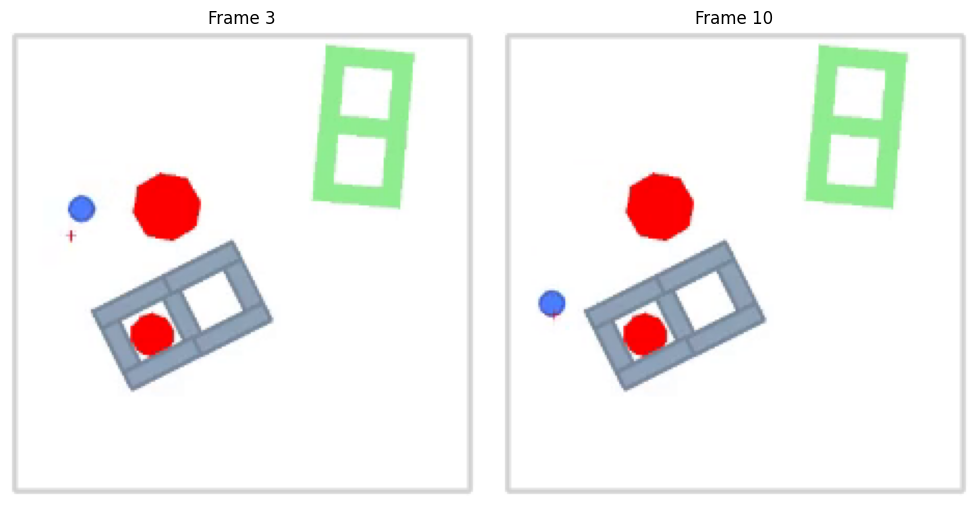

tensor(565.8069)


In [116]:
# 표시할 프레임 인덱스 설정
A_IDX = 3
B_IDX = 10
frame_indices = [A_IDX, B_IDX]  # 원하는 프레임 번호로 변경하세요

# 서브플롯 생성
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# 첫 번째 이미지 표시
axes[0].imshow(frames[frame_indices[0]])
axes[0].set_title(f'Frame {frame_indices[0]}')
axes[0].axis('off')

# 두 번째 이미지 표시
axes[1].imshow(frames[frame_indices[1]])
axes[1].set_title(f'Frame {frame_indices[1]}')
axes[1].axis('off')

# 서브플롯 간 간격 조정
plt.tight_layout()
plt.show()

print(similarity_matrix[A_IDX, B_IDX])
